In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#inspect the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# print the column names and types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    primary_key = ""
    if c['primary_key'] == 1:
        primary_key = "Primary Key"
    print(c['name'], c["type"], primary_key)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [11]:
#print the column names and types for station table
columns = inspector.get_columns('station')
for c in columns:
    primary_key = ""
    if c['primary_key'] == 1:
        primary_key = "Primary Key"
    print(c['name'], c["type"], primary_key)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print('Last date: {}'.format(last_date))


Last date: ('2017-08-23',)


One Year Ago: 2016-08-23


<AxesSubplot:xlabel='date'>

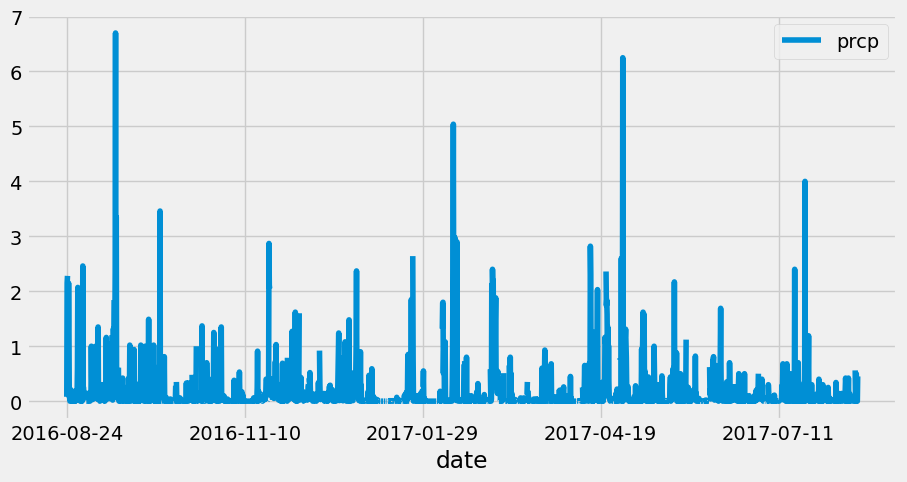

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
sel = [measurement.date, measurement.prcp]

# Calculate the date one year from the last date in data set.
one_year_ago=dt.date(2017,8,23)-dt.timedelta(days=365)
print('One Year Ago: {}'.format(one_year_ago))

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(measurement.date,measurement.prcp).filter(measurement.date>one_year_ago).\
    order_by(measurement.date).all()
precipitation_scores

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_scores_db = pd.DataFrame(precipitation_scores)
precipitation_scores_db = precipitation_scores_db.set_index('date')

# Sort the dataframe by date
precipitation_scores_db = precipitation_scores_db.sort_values(by='date',ascending=True)
precipitation_scores_db.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_scores_db.plot(figsize=(10,5))



In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_scores_db.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
print(f'There are {total_stations} stations in the dataset.')

There are 9 stations in the dataset.


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_number = station_activity[0][0]
session.query(func.min(measurement.tobs), 
              func.max(measurement.tobs), 
              func.avg(measurement.tobs)).filter(measurement.station == station_number).all()

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

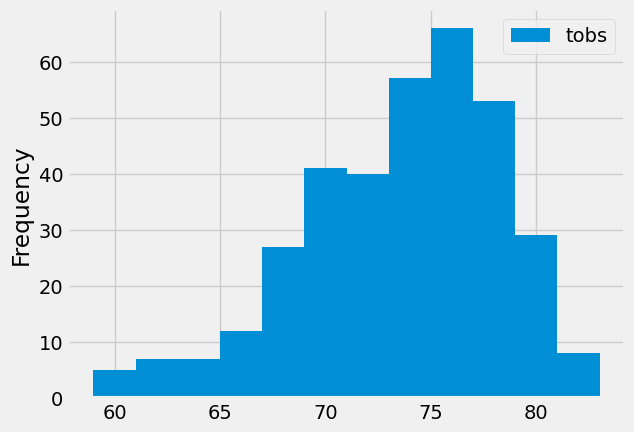

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(measurement.tobs).\
    filter(measurement.station == station_number).\
    filter(measurement.date >= one_year_ago).all()
    
most_act_df = pd.DataFrame(most_active_station, columns=['tobs'])
most_act_df.plot.hist(bins=12)

# Close session

In [19]:
# Close Session
session.close()